In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import re

In [82]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.stem import LancasterStemmer, SnowballStemmer, RegexpStemmer, WordNetLemmatizer
from nltk.tag import pos_tag
import nltk

from textblob import TextBlob
from textblob import Word

from afinn import Afinn

import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
from spacy import displacy

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

In [83]:
df = pd.read_csv('final_df_v3.csv',  index_col='Unnamed: 0')

In [84]:
# Drop NaN Values in Review
df = df.dropna(subset=['review'])

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 705 entries, 0 to 966
Data columns (total 10 columns):
name               705 non-null object
rating             705 non-null object
review_date        705 non-null object
reviewer           705 non-null object
review_url         705 non-null object
neighborhood       704 non-null object
cuisine            510 non-null object
recommendations    436 non-null object
review             705 non-null object
headline           682 non-null object
dtypes: object(10)
memory usage: 60.6+ KB


In [86]:
# Set Review Date to Datetime
df['review_date'] = pd.to_datetime(df['review_date'])

In [87]:
# Get Value Counts for each rating
df['rating'].value_counts()

2 star          227
1 star          193
★                81
★★               74
3 star           56
★★★              19
0.75 star        18
0.5 star          9
Satisfactory      8
Fair              8
4 star            4
★★★★              4
0.25 star         3
Poor              1
Name: rating, dtype: int64

In [88]:
# Categorize Ratings - set all non-starred reviews to 0 Stars
def categorize(rating):
    
    if rating in ['0.25 star', '0.5 star', '0.75 star', 'Fair', 'Satisfactory', 'Poor', 'SATISFACTORY']:
        return '0 star'
    
    elif rating in ['1 star', '★']:
        return '★'
    
    elif rating in ['2 star','★★']:
        return '★★'
    
    elif rating in ['3 star','★★★']:
        return '★★★'
    
    elif rating in ['4 star','★★★★']:
        return '★★★★'

df['rating'] = df['rating'].apply(lambda x: categorize(x))

In [89]:
df['rating'].value_counts()

★★        301
★         274
★★★        75
0 star     47
★★★★        8
Name: rating, dtype: int64

In [90]:
# Add Column with Integer Ratings
def add_num_rating(rating):
    
    if rating == '0 star':
        return 0
    elif rating == '★':
        return 1
    elif rating == '★★':
        return 2
    elif rating == '★★★':
        return 3
    elif rating == '★★★★':
        return 4
    
df['num_rating'] = df['rating'].apply(lambda x: add_num_rating(x))

In [91]:
# Remove unnecessary strings from end of Review
bad_str_1 = 'Follow NYT Food on Twitter and NYT Cooking on Instagram, Facebook, YouTube and Pinterest.'
bad_str_2 = 'Get regular updates from NYT Cooking, with recipe suggestions, cooking tips and shopping advice.'
bad_str_3 = 'What the stars mean: (None) Poor to Satisfactory * Good ** Very Good *** Excellent ****' 
bad_str_4 = 'Extraordinary Ratings reflect the reviewer\'s reaction primarily to food, with ambiance and service taken into consideration.' 
bad_str_5 = 'Menu listings and prices are subject to change.'
bad_str_6 = 'Extraordinary Ratings reflect the reviewer\'s reaction to food, ambiance and service with price taken into consideration.'
bad_str_7 = 'ON THE WEB PAST REVIEWS from the New York Times, with additional capsule reviews by Times critics: nytimes.com/dining'

def del_bad_str(review):
    
    for string in [bad_str_1, bad_str_2, bad_str_3, bad_str_4, bad_str_5, bad_str_6, bad_str_7]:
        
        if string in review:
            
            review = review.replace(string, '').strip()
    
    return review

df['review'] = df['review'].apply(lambda x: del_bad_str(x))

In [92]:
df.head()

name rating review_date    reviewer  \
0              Hanon     ★★  2019-05-21  Pete Wells   
1          Del Posto    ★★★  2019-05-14  Pete Wells   
2  The Freakin Rican      ★  2019-05-07  Pete Wells   
3              Wayan     ★★  2019-04-23  Pete Wells   
4              Niche      ★  2019-04-16  Pete Wells   

                                          review_url     neighborhood  \
0  https://www.nytimes.com/2019/05/21/dining/hano...     Williamsburg   
1  https://www.nytimes.com/2019/05/14/dining/del-...          Chelsea   
2  https://www.nytimes.com/2019/05/07/dining/the-...          Astoria   
3  https://www.nytimes.com/2019/04/23/dining/waya...           NoLIta   
4  https://www.nytimes.com/2019/04/16/dining/nich...  Lower East Side   

                     cuisine  \
0                   Japanese   
1                    Italian   
2  Caribbean, Latin American   
3                 Indonesian   
4                   Japanese   

                                     recommendations  \
0  Japanese omelet; fried chicken with spice; ric...   
1  Grilled salsify salad; vitello tonnato; minest...   
2  Alcapurrias; pasteles; bacalaitos; chicharrone...   
3  Hearts-of-palm salad; clams Jimbaran style; av...   
4  Avocado crunch; yuzu scallop crudo; umami komb...   

                                              review  \
0  Hanon, a new udon shop in Williamsburg, Brookl...   
1  More than a year ago, I was on the verge of re...   
2  It is true that the bacalaitos at the Freakin ...   
3  If you ate at Spice Market before it closed tw...   
4  In 2012 and 2013, when people were lining up a...   

                                            headline  num_rating  
0                  Udon, Innovated for Your Pleasure           2  
1  In Del Posto’s New Era, Cuisine and Service Ar...           3  
2  Pasteles and Two Kinds of Fried Chicken at the...           1  
3     Tapping a Family Connection to Indonesian Food           2  
4  Ramen Without Broth? A Chef Doubles Down on a ...           1

In [93]:
# Group Neighborhoods together by general Area
def hood_to_area(hood):
    
    if hood in ['West Village', 'East Village', 'TriBeCa','SoHo', 'Lower East Side', 'Greenwich Village',
                'NoHo', 'Nolita', 'Financial District', 'Gramercy Park', 'Chinatown', 'Union Square', 
                'Battery Park City', 'Meatpacking District','NoLIta', 'Little Italy', 'Hudson Square','Fulton Ferry']:
        return 'Downtown'
    
    elif hood in ['Midtown', 'Midtown East', 'Midtown South', 'Times Square Theatre District', 'Kips Bay',
                  'Murray Hill', 'Koreatown', 'Hudson Yards', 'Chelsea', 'Flatiron district','Flatiron', 
                  'NoMad', 'Columbus Circle']:
        return 'Midtown'
    
    elif hood in ['Upper East Side', 'Upper West Side', 'Harlem']:
        return 'Uptown'
    
    elif hood in ['Williamsburg','Clinton', 'Park Slope','Greenpoint', 'Gowanus','Prospect Heights', 'Red Hook', 
                  'Carroll Gardens', 'Bushwick', 'Crown Heights', 'Cobble Hill', 'Boerum Hill', 'Fort Greene',
                  'Park Slope North', 'Columbia Street Waterfront District', 'Coney Island', 'Brooklyn Heights', 
                  'Bay Ridge','Ditmas', 'Downtown Brooklyn','Sheepshead Bay', 'Midwood']:
        
        return 'Brooklyn'
    else:
        return 'Other'

df['neighborhood'] = df['neighborhood'].apply(lambda x: hood_to_area(x))

In [94]:
df = df[(df['reviewer'] == 'Pete Wells')|(df['reviewer'] == 'Frank Bruni')|(df['reviewer'] == 'Sam Sifton')]

## EDA

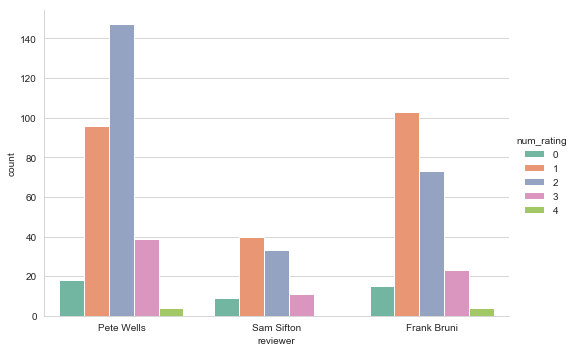

In [95]:
sns.set_style('whitegrid')
sns.catplot(x='reviewer',
            hue='num_rating',
            data=df,
            kind='count',
            height=5, 
            aspect=11.7/8.27,
            palette='Set2');

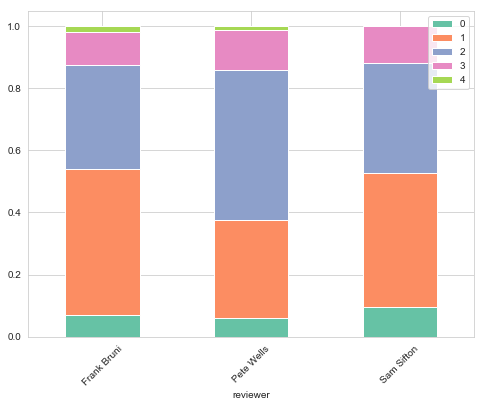

In [97]:
sns.set_palette('Set2')
x = df.groupby('reviewer')['num_rating'].value_counts(normalize=True).unstack()
x.plot(kind='bar', stacked='True', figsize=(8,6))
plt.legend(loc=1)
plt.xticks(rotation=45)
plt.show();

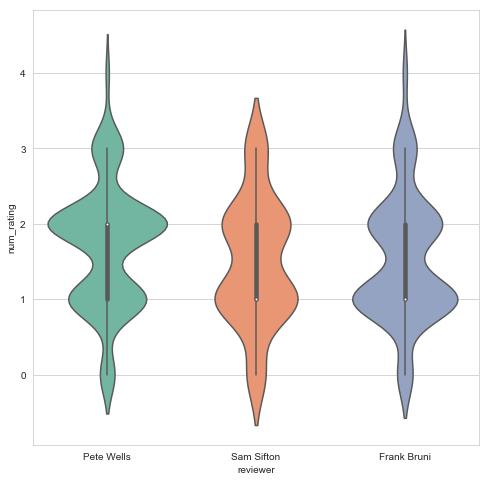

In [101]:
sns.set_palette('Set2')
plt.figure(figsize=(8,8))
sns.violinplot(x='reviewer',
               y='num_rating',
               data=df,
               kind='count');

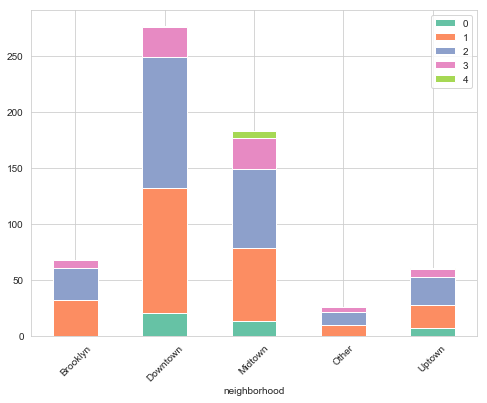

In [102]:
sns.set_palette('Set2')
x = df.groupby('neighborhood')['num_rating'].value_counts().unstack()
x.plot(kind='bar', stacked='True', figsize=(8,6))
plt.legend(loc=1)
plt.xticks(rotation=45)
plt.show();

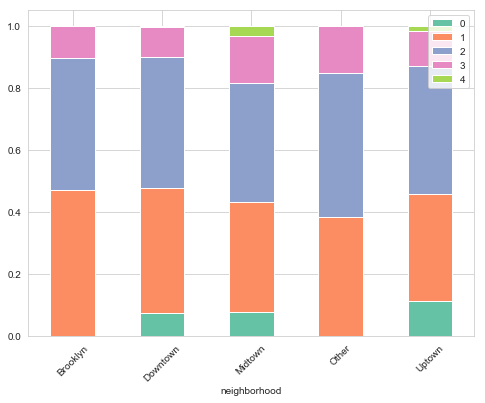

In [104]:
sns.set_palette('Set2')
x = df.groupby('neighborhood')['num_rating'].value_counts(normalize=True).unstack()
x.plot(kind='bar', stacked='True', figsize=(8,6))
plt.legend(loc=1)
plt.xticks(rotation=45)
plt.show();

In [112]:
df.groupby('reviewer')['rating'].value_counts()

reviewer     rating
Frank Bruni  ★         103
             ★★         73
             ★★★        23
             0 star     15
             ★★★★        4
Pete Wells   ★★        147
             ★          96
             ★★★        39
             0 star     18
             ★★★★        4
Sam Sifton   ★          40
             ★★         33
             ★★★        11
             0 star      9
Name: rating, dtype: int64

In [50]:
# Vader Sentiment Function
def run_vader_sentiment(review):
    
    si = SentimentIntensityAnalyzer()
    
    neg_sen = si.polarity_scores(review)['neg']
    neu_sen = si.polarity_scores(review)['neu']
    pos_sen = si.polarity_scores(review)['pos']
    com_sen = si.polarity_scores(review)['compound']
    
    return neg_sen, neu_sen, pos_sen, com_sen

In [51]:
# Run Vader Sentiment on DataFrame
def vader_sentiment(df):
    
    df['neg_sen'] = df['review'].apply(lambda x: run_vader_sentiment(x)[0])
    df['neu_sen'] = df['review'].apply(lambda x: run_vader_sentiment(x)[1])
    df['pos_sen'] = df['review'].apply(lambda x: run_vader_sentiment(x)[2])
    df['com_sen'] = df['review'].apply(lambda x: run_vader_sentiment(x)[2])
    
    return df

df = vader_sentiment(df)

In [55]:
df

name  rating review_date     reviewer  \
0                            Hanon      ★★  2019-05-21   Pete Wells   
1                        Del Posto     ★★★  2019-05-14   Pete Wells   
2                The Freakin Rican       ★  2019-05-07   Pete Wells   
3                            Wayan      ★★  2019-04-23   Pete Wells   
4                            Niche       ★  2019-04-16   Pete Wells   
5                          Haenyeo      ★★  2019-04-09   Pete Wells   
6                   Standard Grill      ★★  2019-04-02   Pete Wells   
7                           Violet       ★  2019-03-26   Pete Wells   
8                              Odo     ★★★  2019-03-19   Pete Wells   
9                     Cka Ka Qellu      ★★  2019-03-12   Pete Wells   
10                   Madame Vo BBQ       ★  2019-03-05   Pete Wells   
11                          Oxalis       ★  2019-02-26   Pete Wells   
12             Bistro Pierre Lapin       ★  2019-02-19   Pete Wells   
13                    Cherry Point      ★★  2019-02-12   Pete Wells   
14                           Benno     ★★★  2019-01-15   Pete Wells   
15                        Bang Bar       ★  2019-01-08   Pete Wells   
16                          Hwaban      ★★  2018-12-31   Pete Wells   
17                 Bluebird London  0 star  2018-12-18   Pete Wells   
18     The Four Seasons Restaurant       ★  2018-12-04   Pete Wells   
19         Saint Julivert Fisherie       ★  2018-11-27   Pete Wells   
20             Adda Indian Canteen      ★★  2018-11-20   Pete Wells   
21                            Misi     ★★★  2018-11-13   Pete Wells   
22                      Mama’s Too       ★  2018-11-06   Pete Wells   
23       Henry at Life Hotel by JJ       ★  2018-10-30   Pete Wells   
24                     Hunan Slurp      ★★  2018-10-23   Pete Wells   
25                          Atomix     ★★★  2018-10-16   Pete Wells   
26                        Manhatta       ★  2018-10-09   Pete Wells   
27                    Village Cafe      ★★  2018-10-02   Pete Wells   
28                        Kopitiam       ★  2018-09-25   Pete Wells   
29      Shoji at 69 Leonard Street     ★★★  2018-09-18   Pete Wells   
..                             ...     ...         ...          ...   
846                       L'Impero      ★★  2007-10-31  Frank Bruni   
849                         Daniel     ★★★  2009-01-20  Frank Bruni   
854                Bar Stuzzichini       ★  2007-09-12  Frank Bruni   
864                       D'or Ahn       ★  2005-11-09  Frank Bruni   
865                    Pasta Flyer       ★  2018-01-23   Pete Wells   
868                         Mercat       ★  2007-07-04  Frank Bruni   
876  Carla Hall’s Southern Kitchen       ★  2016-10-04   Pete Wells   
879                         Lupulo      ★★  2015-07-21   Pete Wells   
881                     Fatty Crab      ★★  2009-05-12  Frank Bruni   
885                        Aquavit     ★★★  2010-07-20   Sam Sifton   
898                     Pok Pok Ny      ★★  2012-06-26   Pete Wells   
900                        Cabrito       ★  2009-01-27  Frank Bruni   
903                        Wassail       ★  2015-12-22   Pete Wells   
908                           Wong      ★★  2012-01-03   Pete Wells   
910                    Brushstroke      ★★  2011-07-12   Sam Sifton   
913                       Centrico       ★  2006-01-04  Frank Bruni   
919                    Pair of 8's       ★  2006-01-18  Frank Bruni   
925                         Tailor       ★  2007-11-21  Frank Bruni   
933                          Ciano      ★★  2011-01-11   Sam Sifton   
937                   Rouge Tomate       ★  2009-01-06  Frank Bruni   
939                           SD26       ★  2009-12-01   Sam Sifton   
943            White Gold Butchers      ★★  2017-02-07   Pete Wells   
945       La Promenade Des Anglais      ★★  2012-01-10   Pete Wells   
946                          Shang       ★  2009-02-17  Frank Bruni   
948                  La Silhouette       ★  2012-05-08

## Headline Sentiment ( TextBlob)

In [114]:
# Run TextBlob Sentiment on Healine
def headline_sent(headline):

    zen = TextBlob(headline)
    return zen.sentiment[0]

df['headline_sentiment'] = df['headline'].apply(lambda x: headline_sent(x))

In [115]:
# Check Results of Headline Sentiment
df.groupby('rating')['headline_sentiment'].describe()

count      mean       std       min  25%  50%       75%   max
rating                                                               
0 star   42.0  0.000433  0.058217 -0.200000  0.0  0.0  0.000000  0.25
★       239.0  0.025093  0.155222 -0.600000  0.0  0.0  0.000000  1.00
★★      253.0  0.016630  0.142970 -0.625000  0.0  0.0  0.000000  0.80
★★★      73.0  0.094565  0.204571 -0.416667  0.0  0.0  0.136364  0.80
★★★★      8.0  0.066667  0.175481  0.000000  0.0  0.0  0.008333  0.50

In [54]:
# Run TextBlob Sentiment

from textblob.sentiments import NaiveBayesAnalyzer

def blob_polarity(review):
    
    polarity = []
    
    for sentence in TextBlob(review).sentences:
        polarity.append(sentence.sentiment[0])
    
    avg_pol = np.mean(polarity)
    min_pol = np.min(polarity)
    max_pol = np.max(polarity)
    std_pol = np.std(polarity)
    
    return avg_pol, min_pol, max_pol, std_pol

def add_blob_pol(df):
    
    df['blob_avg_pol'] = df['review'].apply(lambda x: blob_polarity(x)[0])
    df['blob_min_pol'] = df['review'].apply(lambda x: blob_polarity(x)[1])
    df['blob_max_pol'] = df['review'].apply(lambda x: blob_polarity(x)[2])
    df['blob_std_pol'] = df['review'].apply(lambda x: blob_polarity(x)[3])
    
    # Add Sentiment Dummy based on avg_pol
    df['sentiment'] = np.where(df['blob_avg_pol'] > 0.05, 1, 0)
        
    return df

df = add_blob_pol(df)

In [60]:
# Check Sentiment Dummy breakdown
df['sentiment'].value_counts()

1    555
0     60
Name: sentiment, dtype: int64

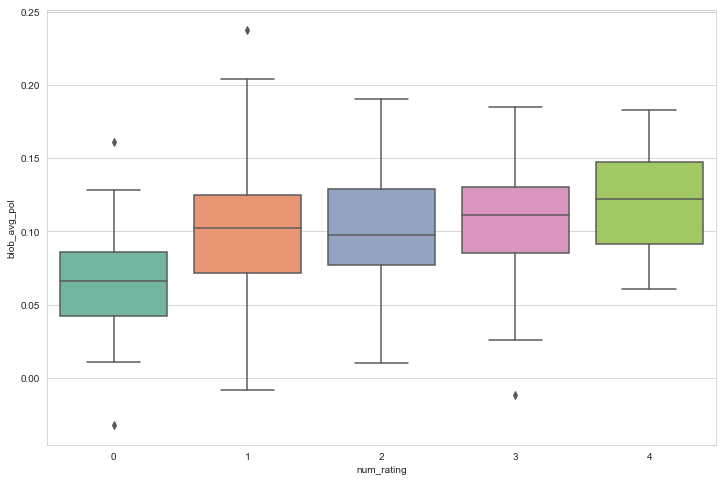

In [58]:
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='num_rating', 
                   y='blob_avg_pol', 
                   data=df, 
                   palette="Set2", 
                   dodge=True)

ax;

In [271]:
# CREATE STOP WORDS LIST
from sklearn.feature_extraction import text 

new_stop_words = [';','.',',','’','“','”','—', ':', '(', ')', 'nyt', '$','would', 'one', 'mr.', \
                  'came', 'table', 'get', 'year', 'water', 'go', 'along', 'first', 'second', \
                  'restaurant', 'new', 'york', 'cooking', 'shop', 'might', 'also', 'make', 'made', 'also'\
                  'food', 'menu', 'meal', 'list', 'dish', 'table', 'dining', 'server', 'food', 'room', 'floor',\
                  'served', 'may', 'want', 'brought', 'night', 'customer', 'said', 'say', 'come', 'dinner', 'le',\
                  'name', 'time', 'chef', '!', 'side', 'day', 'night', 'ate', '?', 'back', 'customers', 'restaurants',\
                  'ingredient', 'cook','dish', 'lunch', 'a.m.', 'p.m.', '\'s', 'way', 'ms.', '--', 'n\'t', 'ms', 'mr', 
                  'like', 'pron', 'del', 'menu', 'menus']

stop_words = stopwords.words('english')

In [272]:
stop_words = list(stop_words) + new_stop_words

In [154]:
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

stop_entities = ['GPE', 'CARDINAL', 'PERSON', 'DATE']

def remove_named_entities(review):
    
    # Get Entities
    nlp = English()
    nlp = en_core_web_sm.load()
    
    doc = nlp(review)
    
    stop_entity_list = []
    entities=[(i, i.label_, i.label) for i in doc.ents]
    
    for entity in entities:
        
        if entity[1] in stop_entities:
            stop_entity_list.append(str(entity[0]).lower())

    return stop_entity_list

In [155]:
df.head()

name rating review_date    reviewer  \
0              Hanon     ★★  2019-05-21  Pete Wells   
1          Del Posto    ★★★  2019-05-14  Pete Wells   
2  The Freakin Rican      ★  2019-05-07  Pete Wells   
3              Wayan     ★★  2019-04-23  Pete Wells   
4              Niche      ★  2019-04-16  Pete Wells   

                                          review_url neighborhood  \
0  https://www.nytimes.com/2019/05/21/dining/hano...     Brooklyn   
1  https://www.nytimes.com/2019/05/14/dining/del-...      Midtown   
2  https://www.nytimes.com/2019/05/07/dining/the-...        Other   
3  https://www.nytimes.com/2019/04/23/dining/waya...     Downtown   
4  https://www.nytimes.com/2019/04/16/dining/nich...     Downtown   

                     cuisine  \
0                   Japanese   
1                    Italian   
2  Caribbean, Latin American   
3                 Indonesian   
4                   Japanese   

                                     recommendations  \
0  Japanese omelet; fried chicken with spice; ric...   
1  Grilled salsify salad; vitello tonnato; minest...   
2  Alcapurrias; pasteles; bacalaitos; chicharrone...   
3  Hearts-of-palm salad; clams Jimbaran style; av...   
4  Avocado crunch; yuzu scallop crudo; umami komb...   

                                              review  \
0  Hanon, a new udon shop in Williamsburg, Brookl...   
1  More than a year ago, I was on the verge of re...   
2  It is true that the bacalaitos at the Freakin ...   
3  If you ate at Spice Market before it closed tw...   
4  In 2012 and 2013, when people were lining up a...   

                                            headline  num_rating  \
0                  Udon, Innovated for Your Pleasure           2   
1  In Del Posto’s New Era, Cuisine and Service Ar...           3   
2  Pasteles and Two Kinds of Fried Chicken at the...           1   
3     Tapping a Family Connection to Indonesian Food           2   
4  Ramen Without Broth? A Chef Doubles Down on a ...           1   

   headline_sentiment                                         lem_review  \
0            0.000000  Hanon , a new udon shop in Williamsburg , Broo...   
1            0.136364  More than a year ago , -PRON- be on the verge ...   
2           -0.600000  -PRON- be true that the bacalaito at the Freak...   
3            0.000000  if -PRON- eat at Spice Market before -PRON- cl...   
4           -0.155556  in 2012 and 2013 , when people be line up at S...   

                                     most_meaningful  
0  [noodle, zenryufun, condom, bran, sasauchi, ge...  
1  [employee, mr, italian, seem, ms, harassment, ...  
2  [pastele, rico, chicharrone, mofongo, plantain...  
3  [indonesian, gado, ochi, spice, satay, market,...  
4  [mazeman, raman, noodle, kombu, abura, bowl, y...

In [156]:
stop_entities = ['GPE', 'CARDINAL', 'PERSON', 'DATE']

def create_stop_list(review):
    
    # Get Entities
    nlp = English()
    nlp = en_core_web_sm.load()
    
    doc = nlp(review)
    
    stop_ent_list = []
    entities=[(i, i.label_, i.label) for i in doc.ents]
    
    for entity in entities:
        
        if entity[1] in stop_entities:
            stop_ent_list.append(str(entity[0]).lower())
            
    return stop_ent_list

entity_stop_list = [create_stop_list(review) for review in df['review']]

In [157]:
entity_stop_list = [word for list_ in entity_stop_list for word in list_]

In [158]:
stop_words_new = stop_words + entity_stop_list

In [159]:
df

name  rating review_date     reviewer  \
0                            Hanon      ★★  2019-05-21   Pete Wells   
1                        Del Posto     ★★★  2019-05-14   Pete Wells   
2                The Freakin Rican       ★  2019-05-07   Pete Wells   
3                            Wayan      ★★  2019-04-23   Pete Wells   
4                            Niche       ★  2019-04-16   Pete Wells   
5                          Haenyeo      ★★  2019-04-09   Pete Wells   
6                   Standard Grill      ★★  2019-04-02   Pete Wells   
7                           Violet       ★  2019-03-26   Pete Wells   
8                              Odo     ★★★  2019-03-19   Pete Wells   
9                     Cka Ka Qellu      ★★  2019-03-12   Pete Wells   
10                   Madame Vo BBQ       ★  2019-03-05   Pete Wells   
11                          Oxalis       ★  2019-02-26   Pete Wells   
12             Bistro Pierre Lapin       ★  2019-02-19   Pete Wells   
13                    Cherry Point      ★★  2019-02-12   Pete Wells   
14                           Benno     ★★★  2019-01-15   Pete Wells   
15                        Bang Bar       ★  2019-01-08   Pete Wells   
16                          Hwaban      ★★  2018-12-31   Pete Wells   
17                 Bluebird London  0 star  2018-12-18   Pete Wells   
18     The Four Seasons Restaurant       ★  2018-12-04   Pete Wells   
19         Saint Julivert Fisherie       ★  2018-11-27   Pete Wells   
20             Adda Indian Canteen      ★★  2018-11-20   Pete Wells   
21                            Misi     ★★★  2018-11-13   Pete Wells   
22                      Mama’s Too       ★  2018-11-06   Pete Wells   
23       Henry at Life Hotel by JJ       ★  2018-10-30   Pete Wells   
24                     Hunan Slurp      ★★  2018-10-23   Pete Wells   
25                          Atomix     ★★★  2018-10-16   Pete Wells   
26                        Manhatta       ★  2018-10-09   Pete Wells   
27                    Village Cafe      ★★  2018-10-02   Pete Wells   
28                        Kopitiam       ★  2018-09-25   Pete Wells   
29      Shoji at 69 Leonard Street     ★★★  2018-09-18   Pete Wells   
..                             ...     ...         ...          ...   
846                       L'Impero      ★★  2007-10-31  Frank Bruni   
849                         Daniel     ★★★  2009-01-20  Frank Bruni   
854                Bar Stuzzichini       ★  2007-09-12  Frank Bruni   
864                       D'or Ahn       ★  2005-11-09  Frank Bruni   
865                    Pasta Flyer       ★  2018-01-23   Pete Wells   
868                         Mercat       ★  2007-07-04  Frank Bruni   
876  Carla Hall’s Southern Kitchen       ★  2016-10-04   Pete Wells   
879                         Lupulo      ★★  2015-07-21   Pete Wells   
881                     Fatty Crab      ★★  2009-05-12  Frank Bruni   
885                        Aquavit     ★★★  2010-07-20   Sam Sifton   
898                     Pok Pok Ny      ★★  2012-06-26   Pete Wells   
900                        Cabrito       ★  2009-01-27  Frank Bruni   
903                        Wassail       ★  2015-12-22   Pete Wells   
908                           Wong      ★★  2012-01-03   Pete Wells   
910                    Brushstroke      ★★  2011-07-12   Sam Sifton   
913                       Centrico       ★  2006-01-04  Frank Bruni   
919                    Pair of 8's       ★  2006-01-18  Frank Bruni   
925                         Tailor       ★  2007-11-21  Frank Bruni   
933                          Ciano      ★★  2011-01-11   Sam Sifton   
937                   Rouge Tomate       ★  2009-01-06  Frank Bruni   
939                           SD26       ★  2009-12-01   Sam Sifton   
943            White Gold Butchers      ★★  2017-02-07   Pete Wells   
945       La Promenade Des Anglais      ★★  2012-01-10   Pete Wells   
946                          Shang       ★  2009-02-17  Frank Bruni   
948                  La Silhouette       ★  2012-05-08

In [160]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [161]:
def spacy_lemmatizer(review):
    
    nlp = spacy.load('en')
    doc = nlp(review)
    
    return ' '.join([token.lemma_ for token in doc])

In [162]:
reviews_lemmatized_spacy = [spacy_lemmatizer(review) for review in df['review']]

In [163]:
tfidf = TfidfVectorizer(stop_words=stop_words_new)
tfidf.fit_transform(reviews_lemmatized_spacy)

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['000', '0000', '0003', '0005', '0012', '0033', '0050', '0082', '0100', '0200', '0202', '0211', '0220', '0228', '0233', '0242', '0300', '0327', '0350', '0404', '0555', '07', '0776', '0880', '0898', '0905', '0955', '1000', '1007', '101', '1012', '105', '1099', '10downingnyc', '10th', '1100', '1105', '1122', '1220', '1234', '1288', '1300', '1313', '138', '1479', '1495', '1500', '1515', '15eastrestaurant', '15th', '1600', '1601', '1660', '175', '1776', '1790', '1833', '189', '18th', '1905', '1919', '1920', '1920s', '1940s', '1990s', '2000s', '2020', '204', '20s', '20th', '2100', '218', '219', '21st', '2222', '226', '2277', '228', '2322', '2328', '2330', '2343', '2400', '2426', '2444', '2590', '2600', '261', '262', '2644', '2680', '2722', '274', '2742', '2777', '2778', '285', '288', '2929', '2950'

<615x22646 sparse matrix of type '<class 'numpy.float64'>'
	with 241864 stored elements in Compressed Sparse Row format>

In [164]:
df['lem_review'] = df['review'].apply(lambda x: spacy_lemmatizer(x))

In [165]:
def find_most_meaningful(review):
    
    vect = tfidf.transform([review])
    
    tfidf_df = pd.DataFrame(vect.T.todense(), index=tfidf.get_feature_names(), columns=['tfidf'])
    
    sorted_df = tfidf_df.sort_values(by=['tfidf'], ascending=False)
    
    return list(sorted_df.index)

df['most_meaningful'] = df['lem_review'].apply(lambda x: find_most_meaningful(x))

In [166]:
def filter_meaningful(row):

    return [x for x in row['most_meaningful'] if x not in row['name'].lower() and x not in ['pron']][:10]

df['most_meaningful'] = df.apply(filter_meaningful, axis=1)

In [167]:
for i in range(len(df)):
    print(df.iloc[i]['name'],',', df.iloc[i]['rating'], '-->', df.iloc[i]['most_meaningful'])

Hanon , ★★ --> ['noodle', 'zenryufun', 'condom', 'bran', 'germ', 'sasauchi', 'soup', 'bamboo', 'dashi', 'company']
Del Posto , ★★★ --> ['employee', 'italian', 'seem', 'harassment', 'cacciatore', 'napkin', 'sexual', 'abuse', 'pasta', 'power']
The Freakin Rican , ★ --> ['pastele', 'rico', 'chicharrone', 'mofongo', 'plantain', 'adela', 'bacalaito', 'wings', 'mojo', 'sancocho']
Wayan , ★★ --> ['indonesian', 'gado', 'ochi', 'spice', 'satay', 'market', 'fruit', 'resort', 'filter', 'vacation']
Niche , ★ --> ['mazeman', 'raman', 'noodle', 'kombu', 'abura', 'bowl', 'yuji', 'shake', 'shio', 'topping']
Haenyeo , ★★ --> ['suni', 'dok', 'korean', 'tteokbokki', 'hwa', 'seaweed', 'mother', 'intimidate', '32nd', 'bibimbap']
Standard Grill , ★★ --> ['pacific', 'changing', 'union', 'game', 'pioneer', 'item', 'charcoal', 'blog', 'return', 'nut']
Violet , ★ --> ['forno', 'pizza', 'rhode', 'pie', 'piri', 'johnnycake', 'emmy', 'island', 'dough', 'havarti']
Odo , ★★★ --> ['kasu', 'shabu', 'course', 'sake', '

In [213]:
from nltk.tokenize import WhitespaceTokenizer
import string
token = WhitespaceTokenizer()

def make_tokens(review, token):
    tokenized_review = token.tokenize(review)
    return tokenized_review

def lower(tokenized_review):
    lowercase_tokens = [token.lower() for token in tokenized_review]
    return lowercase_tokens

def remove_punc(lowercase_tokens):
    stripped_tokens = [token.translate(str.maketrans('', '', string.punctuation)) for token in lowercase_tokens]
    return stripped_tokens

def remove_stopwords(stripped_tokens, stopwords_list):
    stopped_tokens = [token for token in stripped_tokens if token not in stopwords_list]
    return stopped_tokens

def normalize(review, stopword_list, token):
    tokens = make_tokens(review, token)
    lower_tokens = lower(tokens)
    no_punc = remove_punc(lower_tokens)
    stopped = remove_stopwords(no_punc, stopword_list)
    return stopped

In [214]:
df['tokens'] = df['review'].apply(lambda x: normalize(x, stop_words, token))

In [216]:
dfx = df.set_index(df['review_date'])

In [217]:
dfx['year'] = dfx['review_date'].dt.year

In [220]:
pop_word_by_year = {}

for year in dfx['year']:
    
    pop_word_dict = {}
    pop_word_by_year[year] = pop_word_by_year.get(year, pop_word_dict)
    
    for word_list in dfx[dfx['year'] == year]['tokens']:
        
        for word in word_list:
            
            pop_word_dict[word] = pop_word_dict.get(word,0) + 1

In [ ]:
def find_most_meaningful_by_year(review_by_year):
    
    vect = tfidf.transform([review_by_year])
    
    tfidf_df = pd.DataFrame(vect.T.todense(), index=tfidf.get_feature_names(), columns=['tfidf'])
    
    sorted_df = tfidf_df.sort_values(by=['tfidf'], ascending=False)
    
    return list(sorted_df.index)

df['most_meaningful'] = df['lem_review'].apply(lambda x: find_most_meaningful(x))

In [243]:
reviews_by_year_dict = {}

for year in dfx['year']:
    
    reviews_by_year_dict[year] = [spacy_lemmatizer(review) for review in dfx[dfx['year'] == year]['review']]

In [245]:
reviews_by_year_dict

{2019: ['Hanon , a new udon shop in Williamsburg , Brooklyn , be produce by the union of a Tokyo video - production company and a japanese manufacturer of unusually thin condom . the condom become the subject of a series of advertisement on which the production company work ; in one of -PRON- , call “ Acts of Love , " dancer in London re - enact , with surprising grace and dignity , the mate ritual of blue - footed booby , fiddler crab and other animal . well , kid , when two company like each other very much , sometimes -PRON- decide to create a new company together . that be what happen with the production firm and the prophylactic people when , for reason that be perhaps good not to question , -PRON- hit upon the idea of expand -PRON- product line from condom into noodle . the restaurant lie across Union Avenue from Kellogg ’s Diner . -PRON- door be mark during business hour by the fluttering white noren curtain . -PRON- be the second Hanon location . the first be about 6,700 mile a

In [273]:
tfidf = TfidfVectorizer(stop_words=stop_words_new)
tfidf.fit_transform(reviews_lemmatized_spacy)

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['000', '0000', '0003', '0005', '0012', '0033', '0050', '0082', '0100', '0200', '0202', '0211', '0220', '0228', '0233', '0242', '0300', '0327', '0350', '0404', '0555', '07', '0776', '0880', '0898', '0905', '0955', '1000', '1007', '101', '1012', '105', '1099', '10downingnyc', '10th', '1100', '1105', '1122', '1220', '1234', '1288', '1300', '1313', '138', '1479', '1495', '1500', '1515', '15eastrestaurant', '15th', '1600', '1601', '1660', '175', '1776', '1790', '1833', '189', '18th', '1905', '1919', '1920', '1920s', '1940s', '1990s', '2000s', '2020', '204', '20s', '20th', '2100', '218', '219', '21st', '2222', '226', '2277', '228', '2322', '2328', '2330', '2343', '2400', '2426', '2444', '2590', '2600', '261', '262', '2644', '2680', '2722', '274', '2742', '2777', '2778', '285', '288', '2929', '2950'

<615x22646 sparse matrix of type '<class 'numpy.float64'>'
	with 241864 stored elements in Compressed Sparse Row format>

In [280]:
_2017 = ''
for review in reviews_by_year_dict[2017]:
    
    _2017 += review.replace('-PRON-', '')
        
_2017

'usually ,  can take or leave the slice of tomato that come with almost every burger in America . the tomato at John Fraser ’s late restaurant , the Loyal , be the first one  have ever meet that help the burger so much that  become the whole point . Mr. Fraser call  a " 22-step tomato . " and thereby hang a tale , no doubt , but in the interest of time let  skip to the finished product : a peel plum tomato collapse down to a red cushion that more or less cover the patty .  ’ juicy but not gushy , tart and sweet and complex , so  do some of the work normally do by ketchup , but  ’s more dynamic and delicious .  could eat  on  own , but  complete the somewhat austere flavor of the beef from a piedmontese cattle breed . even under a melted sheet of Comté , the patty be not as woozily rich as many contemporary chef - burger . in all ,  ’s an ingenious notion from a chef who be on  fourth current restaurant and seem to be in no imminent danger of run out of idea . the Loyal switch on the li

In [281]:
def most_meaningful_annually(year):
    
    vect = tfidf.transform([year])
    
    tfidf_df = pd.DataFrame(vect.T.todense(), index=tfidf.get_feature_names(), columns=['tfidf'])
    
    sorted_df = tfidf_df.sort_values(by=['tfidf'], ascending=False)
    
    return sorted_df

most_meaningful_annually(_2017)

tfidf
like           0.199043
eat            0.098975
bar            0.093128
flavor         0.085349
could          0.083807
good           0.082877
thing          0.082240
see            0.081082
korean         0.079449
noodle         0.078645
peppe          0.074738
know           0.072272
place          0.070755
pinterest      0.070247
serve          0.069074
pool           0.068835
plate          0.067869
chinese        0.067825
look           0.067387
pork           0.067117
another        0.067014
little         0.066620
try            0.066513
raw            0.065572
take           0.065457
end            0.065387
gold           0.065378
think          0.065276
call           0.064175
people         0.064081
...                 ...
geeky          0.000000
geek           0.000000
gee            0.000000
geddouttahere  0.000000
gear           0.000000
gazillion      0.000000
gazelle        0.000000
gaze           0.000000
gay            0.000000
gawking        0.000000
gelato         0.000000
gelée          0.000000
genetic        0.000000
gelées         0.000000
genesis        0.000000
generously     0.000000
generically    0.000000
generi         0.000000
generator      0.000000
generations    0.000000
generational   0.000000
generate       0.000000
generalize     0.000000
genealogy      0.000000
genderless     0.000000
gender         0.000000
gen            0.000000
gemstone       0.000000
gems           0.000000
être           0.000000

[22646 rows x 1 columns]

In [1058]:
test_tfidf = tfidf.transform()

In [924]:
from textblob.sentiments import NaiveBayesAnalyzer

def blob_polarity(review):
    
    polarity = []
    
    for sentence in TextBlob(review).sentences:
        polarity.append(sentence.sentiment[0])
    
    avg_pol = np.mean(polarity)
    min_pol = np.min(polarity)
    max_pol = np.max(polarity)
    std_pol = np.std(polarity)
    
    return avg_pol, min_pol, max_pol, std_pol

def add_blob_pol(df):
    
    df['blob_avg_pol'] = df['review'].apply(lambda x: blob_polarity(x)[0])
    df['blob_min_pol'] = df['review'].apply(lambda x: blob_polarity(x)[1])
    df['blob_max_pol'] = df['review'].apply(lambda x: blob_polarity(x)[2])
    df['blob_std_pol'] = df['review'].apply(lambda x: blob_polarity(x)[3])
    
    df['sentiment'] = np.where(df['blob_avg_pol'] > 0.05, 1, 0)
        
    return df

df = add_blob_pol(df)

In [931]:
df

name  rating review_date     reviewer  \
0                            Hanon      ★★  2019-05-21   Pete Wells   
1                        Del Posto     ★★★  2019-05-14   Pete Wells   
2                The Freakin Rican       ★  2019-05-07   Pete Wells   
3                            Wayan      ★★  2019-04-23   Pete Wells   
4                            Niche       ★  2019-04-16   Pete Wells   
5                          Haenyeo      ★★  2019-04-09   Pete Wells   
6                   Standard Grill      ★★  2019-04-02   Pete Wells   
7                           Violet       ★  2019-03-26   Pete Wells   
8                              Odo     ★★★  2019-03-19   Pete Wells   
9                     Cka Ka Qellu      ★★  2019-03-12   Pete Wells   
10                   Madame Vo BBQ       ★  2019-03-05   Pete Wells   
11                          Oxalis       ★  2019-02-26   Pete Wells   
12             Bistro Pierre Lapin       ★  2019-02-19   Pete Wells   
13                    Cherry Point      ★★  2019-02-12   Pete Wells   
14                           Benno     ★★★  2019-01-15   Pete Wells   
15                        Bang Bar       ★  2019-01-08   Pete Wells   
16                          Hwaban      ★★  2018-12-31   Pete Wells   
17                 Bluebird London  0 star  2018-12-18   Pete Wells   
18     The Four Seasons Restaurant       ★  2018-12-04   Pete Wells   
19         Saint Julivert Fisherie       ★  2018-11-27   Pete Wells   
20             Adda Indian Canteen      ★★  2018-11-20   Pete Wells   
21                            Misi     ★★★  2018-11-13   Pete Wells   
22                      Mama’s Too       ★  2018-11-06   Pete Wells   
23       Henry at Life Hotel by JJ       ★  2018-10-30   Pete Wells   
24                     Hunan Slurp      ★★  2018-10-23   Pete Wells   
25                          Atomix     ★★★  2018-10-16   Pete Wells   
26                        Manhatta       ★  2018-10-09   Pete Wells   
27                    Village Cafe      ★★  2018-10-02   Pete Wells   
28                        Kopitiam       ★  2018-09-25   Pete Wells   
29      Shoji at 69 Leonard Street     ★★★  2018-09-18   Pete Wells   
..                             ...     ...         ...          ...   
846                       L'Impero      ★★  2007-10-31  Frank Bruni   
849                         Daniel     ★★★  2009-01-20  Frank Bruni   
854                Bar Stuzzichini       ★  2007-09-12  Frank Bruni   
864                       D'or Ahn       ★  2005-11-09  Frank Bruni   
865                    Pasta Flyer       ★  2018-01-23   Pete Wells   
868                         Mercat       ★  2007-07-04  Frank Bruni   
876  Carla Hall’s Southern Kitchen       ★  2016-10-04   Pete Wells   
879                         Lupulo      ★★  2015-07-21   Pete Wells   
881                     Fatty Crab      ★★  2009-05-12  Frank Bruni   
885                        Aquavit     ★★★  2010-07-20   Sam Sifton   
898                     Pok Pok Ny      ★★  2012-06-26   Pete Wells   
900                        Cabrito       ★  2009-01-27  Frank Bruni   
903                        Wassail       ★  2015-12-22   Pete Wells   
908                           Wong      ★★  2012-01-03   Pete Wells   
910                    Brushstroke      ★★  2011-07-12   Sam Sifton   
913                       Centrico       ★  2006-01-04  Frank Bruni   
919                    Pair of 8's       ★  2006-01-18  Frank Bruni   
925                         Tailor       ★  2007-11-21  Frank Bruni   
933                          Ciano      ★★  2011-01-11   Sam Sifton   
937                   Rouge Tomate       ★  2009-01-06  Frank Bruni   
939                           SD26       ★  2009-12-01   Sam Sifton   
943            White Gold Butchers      ★★  2017-02-07   Pete Wells   
945       La Promenade Des Anglais      ★★  2012-01-10   Pete Wells   
946                          Shang       ★  2009-02-17  Frank Bruni   
948                  La Silhouette       ★  2012-05-08

In [986]:
high_freq_universe = [words for words in df['high_freq_tokens']]

[['noodle',
  'udon',
  'soup',
  'company',
  'called',
  'white',
  'zenryufun',
  'tea',
  'sauce',
  'condom',
  'well',
  'like',
  'green',
  'bamboo',
  'tempura',
  'wine',
  'union',
  'japanese',
  'thin',
  'production',
  'idea',
  'lie',
  'door',
  'away',
  'dough'],
 ['del',
  'posto',
  'like',
  'italian',
  'pasta',
  'employee',
  'people',
  'white',
  'seem',
  'course',
  'seems',
  'dessert',
  'pastry',
  'kitchen',
  'expensive',
  'could',
  'though',
  'woman',
  'partner',
  'away',
  'power',
  'spring',
  'everything',
  'together',
  'light'],
 ['rican',
  'freakin',
  'like',
  'rico',
  'chicken',
  'chicharrones',
  'pasteles',
  'pork',
  'around',
  'green',
  'know',
  'mashed',
  'fried',
  'could',
  'start',
  'mofongo',
  'plantain',
  'wing',
  'garlic',
  'grilled',
  'bacalaitos',
  'cod',
  'right',
  'color',
  'corn'],
 ['wayan',
  'spice',
  'sauce',
  'sweet',
  'market',
  'flavor',
  'street',
  'peanut',
  'asian',
  'look',
  'indon

In [176]:
df.to_csv('most_meaningful.csv')